# Selecting Assets IV: Filtering by Beta and Revenue

In [1]:
# Working with data:
import numpy  as np                                   # For scientific computing.
import pandas as pd                                   # Working with tables.

# Downloading files:
import requests, zipfile, io                                # To access websites.

import os

# Specific data providers:
from tiingo import TiingoClient                       # Stock prices.
import quandl                                         # Economic data, futures prices, ...

# API keys:
tiingo = TiingoClient({'api_key':'f10f5d79cf2567b045cc7e9b595a6fec0f5321d2'})
quandl.ApiConfig.api_key = 'EqpCyveK1jFmUkmzpPjz'

# Plotting:
import matplotlib.pyplot as plt                        # Basic plot library.
plt.style.use('ggplot')                                # Make plots look nice

Function for SEC data:

In [2]:
def ffill_values(item, dates):                                          
    data = item.unstack('cik')
    data = data.reindex(dates.union(data.index)).sort_index()           # Add specified dates to index.
    filing_dates = pd.read_csv('data/sec/dates/filing_dates.csv', index_col='cik', parse_dates=['filed']).filed
    last_filing_date_all_firms = filing_dates.max()                     # Most recent date where at least 1 firm filed.
     
    for cik in data.columns:                                            # Loop over all firms.
        last_filing_date      = pd.Series(filing_dates[cik]).iloc[-1]   # Last date where this firm filed
        days_since_last_filed = (last_filing_date_all_firms - last_filing_date).days
        last_date_this_firm   = dates[-1] if days_since_last_filed < 120 else last_filing_date
        data.loc[:last_date_this_firm, cik].ffill(inplace=True)         # Forward fill all the values.

    return data.loc[dates]                                              # Return only specified dates.   

Our rebalance function:

In [3]:
def get_rebalance_dates(frequency, start_date):
    price = PRICE[PRICE.index>start_date]
    group = getattr(price.index, frequency) 
    return price[:1].index.union(price.groupby([price.index.year, group]).tail(1).index)



def run_backtest(frequency, backtest_start='1900-1-1'):   
    
    rebalance_dates = get_rebalance_dates(frequency, backtest_start) 

    portfolio_value = pd.Series(1,                        index=[rebalance_dates[0]])    
    weights         = pd.DataFrame(columns=PRICE.columns, index=[rebalance_dates[0]])
    trades          = pd.DataFrame(columns=PRICE.columns, index=[rebalance_dates[0]])

    previous_positions = weights.iloc[0]
        
    for i in range(1, len(rebalance_dates)-1):
        start_date = rebalance_dates[i]
        end_date   = rebalance_dates[i+1]

        cum_ret = RET[start_date:end_date][1:].add(1).cumprod()
        
        assets        = select_assets(start_date)               # Call "select_assets()"  function to get the assets.
        start_weights = select_weights(start_date, assets)      # Call "select_weights()" function to get the weights
            
        new_positions = portfolio_value.iloc[-1] * start_weights   

        start_to_end_positions = new_positions * cum_ret
        start_to_end_value     = start_to_end_positions.sum('columns')

        portfolio_value = portfolio_value.append(start_to_end_value) 
                
        weights = weights.append(start_to_end_positions.div(start_to_end_value,'rows'))                 
                
        trades.loc[start_date] = new_positions - previous_positions 
        previous_positions     = start_to_end_positions.iloc[-1]      # Previous positions for the next rebalance round

    return portfolio_value.pct_change(), weights, trades

### Get data

Get sales data:

In [4]:
sales = pd.read_csv('data/sec/items/Sales.csv',  parse_dates=['filed'], index_col=['cik','filed'])

Now forward-fill the sales data to all trading days and rename the columns to ticker symbols:

In [5]:
trading_days = pd.to_datetime( tiingo.get_dataframe('SPY','2009-04-15').index ).tz_convert(None)

salesQ = ffill_values( sales.valueQ,  trading_days )
salesA = ffill_values( sales.valueA,  trading_days )


symbols = pd.read_csv('data/ticker_symbols/symbols.csv',index_col=0)

SALESQ = salesQ.rename(columns=symbols.ticker)
SALESA = salesA.rename(columns=symbols.ticker)

Get price data:

In [6]:
PRICE  = pd.read_csv('data/tiingo/close.csv',    index_col='date', parse_dates=['date'])
RET    = pd.read_csv('data/tiingo/adjClose.csv', index_col='date', parse_dates=['date']).pct_change()  
VOLUME = pd.read_csv('data/tiingo/volume.csv',   index_col='date', parse_dates=['date'])
DOLLAR_VOLUME = VOLUME * PRICE

Get benchmark:

In [7]:
vti = tiingo.get_dataframe(['VTI'], '1990-1-1', metric_name='adjClose')
vti.index = pd.to_datetime(vti.index).tz_convert(None)
vti_ret = vti.pct_change().VTI
vti_ret

2001-05-31         NaN
2001-06-01    0.006969
2001-06-04    0.004325
2001-06-05    0.014643
2001-06-06   -0.008489
                ...   
2021-04-22   -0.007813
2021-04-23    0.012115
2021-04-26    0.003637
2021-04-27   -0.000459
2021-04-28   -0.000138
Name: VTI, Length: 5009, dtype: float64

### Calculate betas

Calculate Apple beta:

In [13]:
RET.AAPL.cov(vti_ret) # Apple covariance with VTI

0.00012959136746671998

In [14]:
vti_ret[RET.index[0]:RET.index[-1]].var() # VTI variance

0.0001248869498456314

In [17]:
beta = RET.AAPL.cov(vti_ret) / vti_ret[RET.index[0]:RET.index[-1]].var()
beta

1.0376694092289351

VTI rolling volatility:

In [18]:
vti_ret.std() * 252 ** 0.5

0.19501413752867008

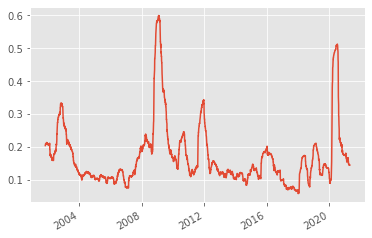

In [22]:
vti_ret.rolling(100).std().multiply(252**0.5).plot()

Apple rolling beta:

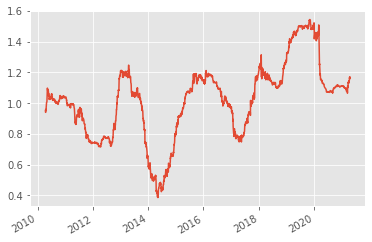

In [25]:
n = 252

cov = RET.AAPL.rolling(n).cov(vti_ret)
var = vti_ret.rolling(n).var()

(cov/var).plot()

Calculate betas for all firms:

In [26]:
n = 252

firms = PRICE.columns
start = PRICE.index[0]
end   = PRICE.index[-1]

var = vti_ret.rolling(n).var()

BETA = pd.DataFrame()

for firm in firms:
    cov        = RET[firm].rolling(n).cov(vti_ret) 
    BETA[firm] = cov / var
    
BETA = BETA[start:end]
BETA

,AIR,ABT,WDDD,ACU,AE,BKTI,AMD,AEM,APD,AKZOF,...,KVSB,TIOAU,MSDAU,GGPIU,NECB,HITIF,AYRWF,OUTR,ABCO,NHLDW
2009-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-12,2.141830,0.642040,0.632524,0.423573,0.850962,0.320253,1.178321,0.389559,0.874190,0.087829,...,NaN,NaN,NaN,NaN,0.284997,1.306246,NaN,1.207911e-16,4.454225e-16,0.081873
2021-04-13,2.118640,0.644229,0.637885,0.426704,0.839602,0.462180,1.203143,0.411725,0.873042,0.087533,...,NaN,NaN,NaN,NaN,0.285076,1.330279,NaN,1.213967e-16,4.476557e-16,0.075675
2021-04-14,2.157536,0.627605,0.476072,0.426066,0.838726,0.626483,1.172730,0.405311,0.877449,0.078932,...,NaN,NaN,NaN,NaN,0.294279,1.329151,NaN,1.240144e-16,4.573084e-16,0.092260
2021-04-15,2.139149,0.654889,0.513148,0.437620,0.840409,0.636852,1.203493,0.417864,0.871474,0.077564,...,NaN,NaN,NaN,NaN,0.294859,1.339083,NaN,1.259350e-16,4.643906e-16,0.077797


Example:

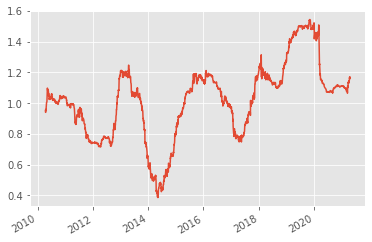

In [27]:
BETA.AAPL.plot()

Backtest high-beta strategy:

In [1]:
def select_assets(date):
    all_firms = PRICE.columns

    p = PRICE        [all_firms].loc[date]
    v = DOLLAR_VOLUME[all_firms].loc[date]
    
    min_price  = p[p>1].index
    min_volume = v[v>100000].index
    
    tradable_assets = min_price.intersection(min_volume)    
        
    assets = BETA[tradable_assets][:date].iloc[-1].nlargest(100).index               # 100 firms with highest betas
    return assets


def select_weights(date, assets):            
    return pd.Series(1/len(assets), index=assets)  
  


high_beta, weights, trades = run_backtest('month', '2011-1-1')

t = high_beta.to_frame('High_beta').join(vti_ret)
t.add(1).cumprod().plot()

NameError: name 'run_backtest' is not defined

Calculate the beta of this portfolio:

In [30]:
high_beta.cov(vti_ret) / vti_ret[ high_beta.index[0] : high_beta.index[-1] ].var()

1.7089390590242304

Rolling beta of this portfolio:

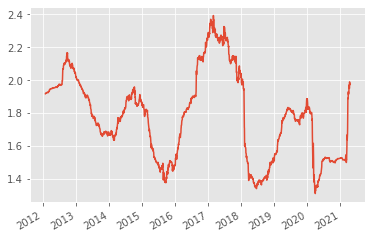

In [31]:
cov = high_beta.rolling(252).cov(vti_ret)
var = vti_ret  .rolling(252).var()
(cov / var).plot()

Low-beta strategy:

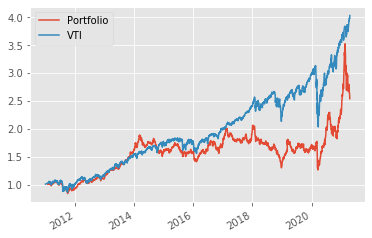

In [32]:
def select_assets(date):
    all_firms = PRICE.columns#.intersection(SALESA.columns)

    p = PRICE        [all_firms].loc[date]
    v = DOLLAR_VOLUME[all_firms].loc[date]
    
    min_price  = p[p>1].index
    min_volume = v[v>100000].index
    
    tradable_assets = min_price.intersection(min_volume)    
        
    assets = BETA[tradable_assets][:date].iloc[-1].nsmallest(100).index           # 100 firms with lowest betas
    return assets
  


low_beta, weights, trades = run_backtest('month', '2011-1-1')

t = low_beta.to_frame('Portfolio').join(vti.pct_change())
t.add(1).cumprod().plot()

Calculate the beta of this portfolio:

In [33]:
low_beta.cov(vti_ret) / vti_ret[ low_beta.index[0] : low_beta.index[-1] ].var()

0.4128645359128367

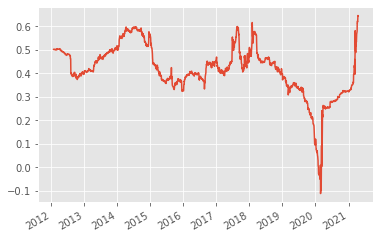

In [34]:
cov = low_beta.rolling(252).cov(vti_ret)
var = vti_ret.rolling(252).var()
(cov / var).plot()

Among 500 firms with highest average volume during the last 30 tradig days, select the 100 firms with lowest beta:

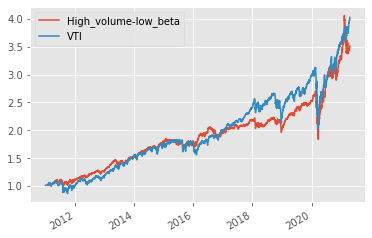

In [35]:
def select_assets(date):
    
    high_volume = DOLLAR_VOLUME[:date][-30:].mean().nlargest(500).index
    assets      = BETA[high_volume][:date].iloc[-1].nsmallest(100).index

    return assets



high_volume_low_beta, weights, trades = run_backtest('month', '2011-1-1')

t = high_volume_low_beta.to_frame('High_volume-low_beta').join(vti.pct_change())
t.add(1).cumprod().plot()

Volatilities:

In [36]:
t.std() * 252**0.5

High_volume-low_beta    0.146432
VTI                     0.175707
dtype: float64

Compare drawdowns:

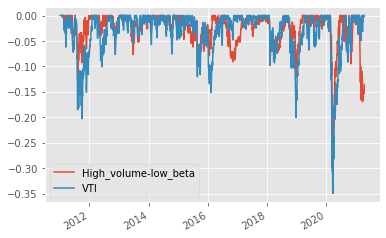

In [37]:
hwm = t.add(1).cumprod().cummax()         # cummax: maximum value from 1st row to current row (date)

drawdown = t.add(1).cumprod()/hwm - 1.0   # % portfolio loss relative to most recent peak (high water mark)
drawdown.plot()

Select 50 firms with highest annual sales among the 100 firms with lowest beta (among all tradable assets):

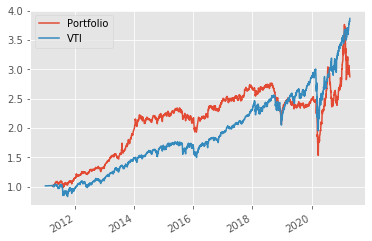

In [38]:
def select_assets(date):
    all_firms = PRICE.columns.intersection(SALESA.columns)    

    p = PRICE        [all_firms].loc[date]
    v = DOLLAR_VOLUME[all_firms].loc[date]
    
    min_price  = p[p>1].index
    min_volume = v[v>100000].index
    
    tradable_assets = min_price.intersection(min_volume)
    
    low_beta = BETA[tradable_assets][:date].iloc[-1].nsmallest(100).index
    
    assets   = SALESA[low_beta][:date].iloc[-1].nlargest(50).index
    return assets


portfolio, weights, trades = run_backtest('quarter', '2011-1-1')

t = portfolio.to_frame('Portfolio').join(vti.pct_change())
t.add(1).cumprod().plot()

Select 50 firms with lowest beta among the 100 firms with highest annual sales (among all tradable assets):

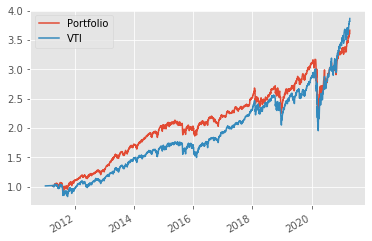

In [39]:
def select_assets(date):
    all_firms = PRICE.columns.intersection(SALESA.columns)    

    p = PRICE        [all_firms].loc[date]
    v = DOLLAR_VOLUME[all_firms].loc[date]
    
    min_price  = p[p>1].index
    min_volume = v[v>100000].index
    
    tradable_assets = min_price.intersection(min_volume)
   
    high_sales = SALESA[tradable_assets][:date].iloc[-1].nlargest(100).index
    assets   = BETA[high_sales][:date].iloc[-1].nsmallest(50).index

    return assets


portfolio, weights, trades = run_backtest('quarter', '2011-1-1')

t = portfolio.to_frame('Portfolio').join(vti.pct_change())
t.add(1).cumprod().plot()

Select firms that have both low beta and high sales:

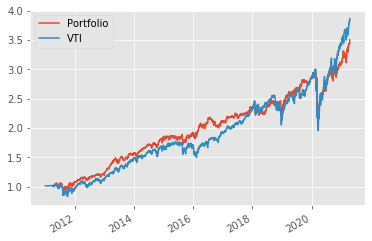

In [41]:
def select_assets(date):
    all_firms = PRICE.columns.intersection(SALESA.columns)    

    p = PRICE        [all_firms].loc[date]
    v = DOLLAR_VOLUME[all_firms].loc[date]
    
    min_price  = p[p>1].index
    min_volume = v[v>100000].index
    
    tradable_assets = min_price.intersection(min_volume)
   
    high_sales = SALESA[tradable_assets][:date].iloc[-1].nlargest(500).index
    low_beta   = BETA  [tradable_assets][:date].iloc[-1].nsmallest(500).index

    assets = high_sales.intersection(low_beta)
    
    return assets


portfolio, weights, trades = run_backtest('quarter', '2011-1-1')

t = portfolio.to_frame('Portfolio').join(vti.pct_change())
t.add(1).cumprod().plot()

How many assets?

In [47]:
weights.count('columns')

2011-01-03      0
2011-04-01    151
2011-04-04    151
2011-04-05    151
2011-04-06    151
             ... 
2021-04-12     76
2021-04-13     76
2021-04-14     76
2021-04-15     76
2021-04-16     76
Length: 2528, dtype: int64

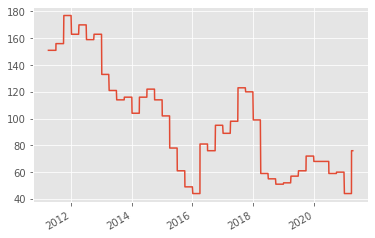

In [48]:
weights[1:].count('columns').plot()